In [1]:
import os
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
import pathlib
import pickle
from itertools import product
from scipy.stats import skew, kurtosis, wilcoxon
from scipy.signal import butter, welch, filtfilt, resample
from scipy import stats

from sklearn import metrics, neighbors, linear_model, preprocessing, svm
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, LeaveOneGroupOut, KFold, StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from PreprocessFcns import *

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set_context('talk',font_scale=1)

In [64]:
def LOSOCV(Data,X,y,groups,models,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                #print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                #print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)
            
            #the recall per task - TO BE COMPLETED
            
#             tasks=Data.iloc[test_index,:].Task
#             for t in tasks.unique():
#                 tasks
            
            #compute ROC points at fixed fpr (to plot error bars)
            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            #print('\nSubj/Visit %d, prec=%.3f, rec=%.3f, Spec=%.3f, auroc_train=%.3f, auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),
            #                                                                     spec,auroc_train,auroc))
            s+=1

        print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 'auroc':np.nanmean(auroc_all)}
                        ,index=[0])
        results = pd.concat((results,r))
        
    return results,groupres 
    

#train multiple classifiers using stratified kfold
def trainmodel_Kfold(Xf,y,models,nfolds=5,balance=False):

    scaler = StandardScaler()
    f1_fold_clf=[]; auc_fold_clf=[]; cmats={}

    skf = StratifiedKFold(n_splits=nfolds,shuffle=True,random_state=46)
        
    for clf,model_name in models:
        f1_fold = []; f1_train_fold=[]; prec_fold=[]; rec_fold=[]; auprc_fold=[]

        for train_idx,test_idx in skf.split(Xf,y):
            Xtr = Xf[train_idx]
            ytr = y[train_idx]
            if balance:
                #balance dataset
                indsp = np.where(ytr==1)[0]
                indsn = np.random.choice(np.where(ytr==0)[0],size=round(1*len(indsp)),replace=False)
                inds = np.hstack((indsp,indsn))
                Xtr = Xtr[inds]; ytr = ytr[inds]
#             print(len(ytr[ytr==0])/len(ytr[ytr>0]))
            Xte = Xf[test_idx]
            yte = y[test_idx]
            Xtr = scaler.fit_transform(Xtr)
            Xte = scaler.transform(Xte)
            clf.fit(Xtr,ytr)
            ypred_train = clf.predict(Xtr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train and test set for current fold
            precision, recall, _ = precision_recall_curve(yte,yscore)
            
            f1_train_fold.append(f1_score(ytr,ypred_train))
            f1_fold.append(f1_score(yte,ypred))
            prec_fold.append(precision_score(yte,ypred))
            rec_fold.append(recall_score(yte,ypred))
            auprc_fold.append(auc(recall,precision)
)


        #mean accuracy across folds
        if balance:
            print('Npos = %d, Nneg = %d'%(len(indsp),len(indsn)))
            
        print('%s'%model_name)
        print('f1_train=%.3f+/-%.3f, f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f'%(
        np.nanmean(f1_train_fold),np.nanstd(f1_train_fold),
        np.nanmean(f1_fold),np.nanstd(f1_fold),
        np.nanmean(prec_fold),np.nanstd(prec_fold), np.nanmean(rec_fold),np.nanstd(rec_fold),
        np.nanmean(auprc_fold),np.nanstd(auprc_fold)))
        
        cf_matrix = confusion_matrix(yte, ypred)
        print(cf_matrix)
        #store f1 and auc for each fold and clf
        f1_fold_clf.append(f1_fold)
        auc_fold_clf.append(auprc_fold)
        #store cmat for each clf (on last fold)
        cmats.update({model_name:cf_matrix})
        
    return f1_fold_clf, auc_fold_clf, cmats

    
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    

def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if plotname=='Threshold':
        ls = '-'
    else:
        ls='-'
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=3,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=3,linestyle=ls)
             
    lw = 3
    
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.legend(loc='lower right')
    
    return ax

def LOSOCV_Tasks(Data,X,y,groups,tasks,clf):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each task subset


    #train multiple classifiers
    for T in tasks:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]
          
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
            task_inds = Data.Task.iloc[test_index]==T[0]
            for Ti in T[1::]:
                task_inds = task_inds | (Data.Task.iloc[test_index]==Ti)
            test_index = test_index[task_inds]
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]

            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])

            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)

            #the recall per task - TO BE COMPLETED

#             tasks=Data.iloc[test_index,:].Task
#             for t in tasks.unique():
#                 tasks

            #compute ROC points at fixed fpr (to plot error bars)
            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)

            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)

            s+=1

        #group results for each model
        groupres[tuple(T)] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}

        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 'auroc':np.nanmean(auroc_all)}
                        ,index=[0])
        results = pd.concat((results,r))
        
    return results,groupres 
    

In [3]:
folder_path = r'Z:CIS-PD Study'
subjects_path = r'Z:\CIS-PD Study\Subjects' #Windows remote path
dict_path = 'Z:\CIS-PD Study\Data_dict'
scores_path = r'Z:\CIS-PD Study\Scores' #remote repo
features_path = r'Z:\CIS-PD Study\FeatureMatrix' #remote repo
results_path = r'C:\Users\LU-RT&O\Documents\Git\Results'

In [66]:
symptom = 'Tremor'

watch_res_all = pd.DataFrame()

t1=time.time()

for freq in [50,45,40,35,30,25,20,15,10,5]:
    
    print(freq)

    Dataorig = pd.read_csv('Z:CIS-PD Study\\Smartwatch Data ' + str(freq) + 'Hz.csv',index_col=0)
    Dataorig = Dataorig.reset_index(drop=True)

    Dataorig=Dataorig[Dataorig.Subject!=1020]

    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    for s in Data.columns.values[4:]:
        Data = Data[Data[s]<np.finfo(np.float32).max]
    Data=Data.reset_index(drop=True) #reset index

    X = Data.iloc[:,5:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,5:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    #print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
    model_name = ['Random Forest']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X,y,groups,models)
    res['Sampling Rate'] = str(freq) + ' Hz'
    res['auroc std'] = np.nanstd(res_group['Random Forest']['auroc'])
    res = res[['Sampling Rate','auroc','auroc std']]
    watch_res_all = pd.concat((watch_res_all,res))

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

50
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.364+/-0.225, prec=0.485+/-0.324, rec=0.354+/-0.190, auprc=0.527+/-0.282, auroc=0.772+/-0.186
45
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.368+/-0.240, prec=0.482+/-0.330, rec=0.363+/-0.199, auprc=0.523+/-0.281, auroc=0.778+/-0.181
40
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.364+/-0.225, prec=0.485+/-0.324, rec=0.354+/-0.190, auprc=0.527+/-0.282, auroc=0.772+/-0.186
35
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.351+/-0.215, prec=0.468+/-0.319, rec=0.314+/-0.191, auprc=0.502+/-0.282, auroc=0.767+/-0.186
30
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.373+/-0.235, prec=0.502+/-0.331, rec=0.321+/-0.201, auprc=0.517+/-0.279, auroc=0.766+/-0.186
25
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.377+/-0.225, prec=0.489+/-0.312, rec=0.341+/-0.214, auprc=0.519+/-0.279, auroc=0.760+/-0.187
20
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.364+/-0.205, prec=0.504+/-0.315, rec=0.315+/-0.183, auprc=0.509+/-0.268, auroc=0.750+/-0.185
15
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.301+/-0.179, prec=0.441+/-0.303, rec=0.279+/-0.191, auprc=0.448+/-0.256, auroc=0.715+/-0.175
10
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.280+/-0.152, prec=0.416+/-0.277, rec=0.298+/-0.268, auprc=0.451+/-0.231, auroc=0.681+/-0.185
5
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-d

f1_test=0.228+/-0.186, prec=0.418+/-0.346, rec=0.184+/-0.162, auprc=0.497+/-0.285, auroc=0.603+/-0.189
Elapsed time = 5.188 min


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [67]:
watch_res_all

,Sampling Rate,auroc,auroc std
0,50 Hz,0.772263,0.185878
0,45 Hz,0.777706,0.181367
0,40 Hz,0.772263,0.185878
0,35 Hz,0.767213,0.185945
0,30 Hz,0.766383,0.185821
0,25 Hz,0.759634,0.186791
0,20 Hz,0.750122,0.185305
0,15 Hz,0.715119,0.175084
0,10 Hz,0.681410,0.185155
0,5 Hz,0.602967,0.189256


Text(0.5,1,'Effect of Sampling Frequency on AUROC: Tremor')

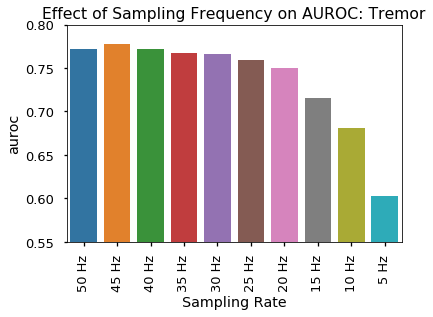

In [69]:
groups = watch_res_all['Sampling Rate']
aurocall = watch_res_all['auroc']
sns.barplot(groups,aurocall)
ax=plt.xticks(rotation=90)
plt.ylim([0.55,0.8])
plt.title('Effect of Sampling Frequency on AUROC: Tremor')

In [70]:
symptom = 'Bradykinesia'

watch_res_all = pd.DataFrame()

t1=time.time()

for freq in [50,45,40,35,30,25,20,15,10,5]:
    print(freq)

    Dataorig = pd.read_csv('Z:CIS-PD Study\\Smartwatch Data ' + str(freq) + 'Hz.csv',index_col=0)
    Dataorig = Dataorig.reset_index(drop=True)

    Dataorig=Dataorig[Dataorig.Subject!=1020]

    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    for s in Data.columns.values[4:]:
        Data = Data[Data[s]<np.finfo(np.float32).max]
    Data=Data.reset_index(drop=True) #reset index

    X = Data.iloc[:,5:].as_matrix()
    fnames = Data.iloc[:,5:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    #print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
    model_name = ['Random Forest']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X,y,groups,models)
    res['Sampling Rate'] = str(freq) + ' Hz'
    res['auroc std'] = np.nanstd(res_group['Random Forest']['auroc'])
    res = res[['Sampling Rate','auroc','auroc std']]
    watch_res_all = pd.concat((watch_res_all,res))

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

50
Training Random Forest
f1_test=0.575+/-0.228, prec=0.594+/-0.280, rec=0.692+/-0.183, auprc=0.623+/-0.269, auroc=0.613+/-0.132
45
Training Random Forest
f1_test=0.576+/-0.231, prec=0.590+/-0.284, rec=0.691+/-0.178, auprc=0.630+/-0.275, auroc=0.621+/-0.127
40
Training Random Forest
f1_test=0.575+/-0.228, prec=0.594+/-0.280, rec=0.692+/-0.183, auprc=0.623+/-0.269, auroc=0.613+/-0.132
35
Training Random Forest
f1_test=0.584+/-0.229, prec=0.597+/-0.281, rec=0.698+/-0.168, auprc=0.620+/-0.267, auroc=0.622+/-0.127
30
Training Random Forest
f1_test=0.584+/-0.229, prec=0.596+/-0.282, rec=0.703+/-0.171, auprc=0.624+/-0.267, auroc=0.626+/-0.122
25
Training Random Forest
f1_test=0.575+/-0.220, prec=0.593+/-0.281, rec=0.685+/-0.169, auprc=0.628+/-0.269, auroc=0.630+/-0.124
20
Training Random Forest
f1_test=0.585+/-0.226, prec=0.599+/-0.281, rec=0.696+/-0.170, auprc=0.626+/-0.265, auroc=0.635+/-0.119
15
Training Random Forest
f1_test=0.592+/-0.227, prec=0.598+/-0.280, rec=0.707+/-0.164, auprc=0.6

In [71]:
watch_res_all

,Sampling Rate,auroc,auroc std
0,50 Hz,0.612893,0.131556
0,45 Hz,0.620917,0.126945
0,40 Hz,0.612893,0.131556
0,35 Hz,0.621693,0.126614
0,30 Hz,0.625898,0.122432
0,25 Hz,0.630323,0.123638
0,20 Hz,0.635393,0.118621
0,15 Hz,0.641606,0.109230
0,10 Hz,0.621350,0.099005
0,5 Hz,0.628064,0.159986


Text(0.5,1,'Effect of Sampling Frequency on AUROC: Bradykinesia')

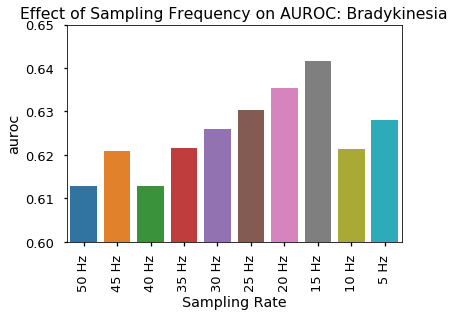

In [72]:
groups = watch_res_all['Sampling Rate']
aurocall = watch_res_all['auroc']
sns.barplot(groups,aurocall)
ax=plt.xticks(rotation=90)
plt.ylim([0.6,0.65])
plt.title('Effect of Sampling Frequency on AUROC: Bradykinesia')

In [54]:
symptom = 'Tremor'

sensor_res_all = pd.DataFrame()

t1=time.time()

for freq in [62.5,57.5,52.5,47.5,42.5,37.5,32.5,27.5,22.5,17.5,12.5,7.5,2.5]:

    Dataorig = pd.read_csv('Z:CIS-PD Study\\Accel Data ' + str(freq) + 'Hz.csv',index_col=0)
    Dataorig = Dataorig.reset_index(drop=True)

    Dataorig=Dataorig[Dataorig.Subject!=1020]

    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    for s in Data.columns.values[4:]:
        Data = Data[Data[s]<np.finfo(np.float32).max]
    Data=Data.reset_index(drop=True) #reset index

    X = Data.iloc[:,5:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,5:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
    model_name = ['Random Forest']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X,y,groups,models)
    res['Sampling Rate'] = str(freq) + ' Hz'
    res['auroc std'] = np.nanstd(res_group['Random Forest']['auroc'])
    res = res[['Sampling Rate','auroc','auroc std']]
    sensor_res_all = pd.concat((sensor_res_all,res))

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Tremor 11184/45376 = 0.25
Training Random Forest

Subj/Visit 0, prec=0.210, rec=0.150, Spec=0.929, auroc_train=1.000, auroc=0.677

Subj/Visit 1, prec=0.608, rec=0.065, Spec=0.965, auroc_train=1.000, auroc=0.723

Subj/Visit 2, prec=0.381, rec=0.103, Spec=0.975, auroc_train=1.000, auroc=0.686

Subj/Visit 3, prec=0.143, rec=0.250, Spec=0.899, auroc_train=1.000, auroc=0.684

Subj/Visit 4, prec=0.414, rec=0.123, Spec=0.936, auroc_train=1.000, auroc=0.645

Subj/Visit 5, prec=0.616, rec=0.264, Spec=0.888, auroc_train=1.000, auroc=0.706

Subj/Visit 6, prec=0.678, rec=0.282, Spec=0.982, auroc_train=1.000, auroc=0.811

Subj/Visit 7, prec=0.512, rec=0.180, Spec=0.986, auroc_train=1.000, auroc=0.766

Subj/Visit 8, prec=0.940, rec=0.248, Spec=0.980, auroc_train=1.000, auroc=0.762

Subj/Visit 9, prec=0.327, rec=0.269, Spec=0.953, auroc_train=1.000, auroc=0.796

Subj/Visit 10, prec=0.314, rec=0.111, Spec=0.934, auroc_train=1.000, auroc=0.546

Subj/Visit 11, prec=0.017, rec=0.034, Spec=0.967, a

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.970, auroc_train=1.000, auroc=nan

Subj/Visit 16, prec=0.008, rec=0.036, Spec=0.941, auroc_train=1.000, auroc=0.611

Subj/Visit 17, prec=0.885, rec=0.137, Spec=0.916, auroc_train=1.000, auroc=0.560

Subj/Visit 18, prec=0.934, rec=0.251, Spec=0.944, auroc_train=1.000, auroc=0.672
f1_test=0.221+/-0.161, prec=0.417+/-0.316, rec=0.176+/-0.124, auprc=0.381+/-0.292, auroc=0.703+/-0.077
Rows w Tremor 11184/45376 = 0.25
Training Random Forest

Subj/Visit 0, prec=0.208, rec=0.131, Spec=0.937, auroc_train=1.000, auroc=0.677

Subj/Visit 1, prec=0.650, rec=0.068, Spec=0.969, auroc_train=1.000, auroc=0.695

Subj/Visit 2, prec=0.439, rec=0.116, Spec=0.978, auroc_train=1.000, auroc=0.687

Subj/Visit 3, prec=0.159, rec=0.282, Spec=0.900, auroc_train=1.000, auroc=0.693

Subj/Visit 4, prec=0.404, rec=0.109, Spec=0.942, auroc_train=1.000, auroc=0.649

Subj/Visit 5, prec=0.624, rec=0.259, Spec=0.893, auroc_t

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.962, auroc_train=1.000, auroc=nan

Subj/Visit 16, prec=0.000, rec=0.000, Spec=0.940, auroc_train=1.000, auroc=0.587

Subj/Visit 17, prec=0.858, rec=0.120, Spec=0.907, auroc_train=1.000, auroc=0.560

Subj/Visit 18, prec=0.942, rec=0.256, Spec=0.950, auroc_train=1.000, auroc=0.676
f1_test=0.216+/-0.159, prec=0.419+/-0.314, rec=0.176+/-0.131, auprc=0.379+/-0.288, auroc=0.699+/-0.077
Rows w Tremor 11184/45376 = 0.25
Training Random Forest

Subj/Visit 0, prec=0.222, rec=0.146, Spec=0.936, auroc_train=1.000, auroc=0.666

Subj/Visit 1, prec=0.570, rec=0.049, Spec=0.969, auroc_train=1.000, auroc=0.687

Subj/Visit 2, prec=0.384, rec=0.106, Spec=0.975, auroc_train=1.000, auroc=0.689

Subj/Visit 3, prec=0.164, rec=0.301, Spec=0.897, auroc_train=1.000, auroc=0.700

Subj/Visit 4, prec=0.415, rec=0.114, Spec=0.941, auroc_train=1.000, auroc=0.654

Subj/Visit 5, prec=0.604, rec=0.259, Spec=0.884, auroc_t

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.960, auroc_train=1.000, auroc=nan

Subj/Visit 16, prec=0.016, rec=0.071, Spec=0.939, auroc_train=1.000, auroc=0.690

Subj/Visit 17, prec=0.872, rec=0.121, Spec=0.916, auroc_train=1.000, auroc=0.568

Subj/Visit 18, prec=0.943, rec=0.245, Spec=0.953, auroc_train=1.000, auroc=0.671
f1_test=0.220+/-0.157, prec=0.410+/-0.309, rec=0.184+/-0.125, auprc=0.376+/-0.287, auroc=0.698+/-0.072
Rows w Tremor 11184/45376 = 0.25
Training Random Forest

Subj/Visit 0, prec=0.209, rec=0.146, Spec=0.931, auroc_train=1.000, auroc=0.662

Subj/Visit 1, prec=0.545, rec=0.056, Spec=0.961, auroc_train=1.000, auroc=0.701

Subj/Visit 2, prec=0.458, rec=0.122, Spec=0.979, auroc_train=1.000, auroc=0.698

Subj/Visit 3, prec=0.178, rec=0.321, Spec=0.900, auroc_train=1.000, auroc=0.690

Subj/Visit 4, prec=0.406, rec=0.095, Spec=0.949, auroc_train=1.000, auroc=0.663

Subj/Visit 5, prec=0.598, rec=0.257, Spec=0.882, auroc_t

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.962, auroc_train=1.000, auroc=nan

Subj/Visit 16, prec=0.000, rec=0.000, Spec=0.942, auroc_train=1.000, auroc=0.574

Subj/Visit 17, prec=0.863, rec=0.136, Spec=0.899, auroc_train=1.000, auroc=0.556

Subj/Visit 18, prec=0.929, rec=0.253, Spec=0.939, auroc_train=1.000, auroc=0.671
f1_test=0.215+/-0.153, prec=0.412+/-0.308, rec=0.176+/-0.124, auprc=0.377+/-0.289, auroc=0.694+/-0.077
Rows w Tremor 11184/45376 = 0.25
Training Random Forest

Subj/Visit 0, prec=0.227, rec=0.146, Spec=0.938, auroc_train=1.000, auroc=0.654

Subj/Visit 1, prec=0.615, rec=0.061, Spec=0.968, auroc_train=1.000, auroc=0.711

Subj/Visit 2, prec=0.478, rec=0.138, Spec=0.978, auroc_train=1.000, auroc=0.662

Subj/Visit 3, prec=0.171, rec=0.314, Spec=0.898, auroc_train=1.000, auroc=0.686

Subj/Visit 4, prec=0.443, rec=0.097, Spec=0.956, auroc_train=1.000, auroc=0.659

Subj/Visit 5, prec=0.628, rec=0.264, Spec=0.893, auroc_t

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.960, auroc_train=1.000, auroc=nan

Subj/Visit 16, prec=0.000, rec=0.000, Spec=0.940, auroc_train=1.000, auroc=0.617

Subj/Visit 17, prec=0.843, rec=0.116, Spec=0.899, auroc_train=1.000, auroc=0.563

Subj/Visit 18, prec=0.919, rec=0.238, Spec=0.934, auroc_train=1.000, auroc=0.672
f1_test=0.213+/-0.156, prec=0.417+/-0.309, rec=0.171+/-0.125, auprc=0.379+/-0.290, auroc=0.696+/-0.075
Rows w Tremor 11184/45376 = 0.25
Training Random Forest

Subj/Visit 0, prec=0.178, rec=0.113, Spec=0.934, auroc_train=1.000, auroc=0.655

Subj/Visit 1, prec=0.602, rec=0.055, Spec=0.969, auroc_train=1.000, auroc=0.719

Subj/Visit 2, prec=0.382, rec=0.109, Spec=0.974, auroc_train=1.000, auroc=0.672

Subj/Visit 3, prec=0.175, rec=0.308, Spec=0.902, auroc_train=1.000, auroc=0.694

Subj/Visit 4, prec=0.417, rec=0.078, Spec=0.961, auroc_train=1.000, auroc=0.659

Subj/Visit 5, prec=0.611, rec=0.271, Spec=0.882, auroc_t

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.960, auroc_train=1.000, auroc=nan

Subj/Visit 16, prec=0.007, rec=0.036, Spec=0.934, auroc_train=1.000, auroc=0.626

Subj/Visit 17, prec=0.854, rec=0.115, Spec=0.907, auroc_train=1.000, auroc=0.572

Subj/Visit 18, prec=0.940, rec=0.247, Spec=0.950, auroc_train=1.000, auroc=0.666
f1_test=0.208+/-0.159, prec=0.404+/-0.310, rec=0.164+/-0.125, auprc=0.376+/-0.289, auroc=0.694+/-0.075
Rows w Tremor 11184/45376 = 0.25
Training Random Forest

Subj/Visit 0, prec=0.245, rec=0.135, Spec=0.948, auroc_train=1.000, auroc=0.655

Subj/Visit 1, prec=0.566, rec=0.062, Spec=0.960, auroc_train=1.000, auroc=0.713

Subj/Visit 2, prec=0.464, rec=0.125, Spec=0.979, auroc_train=1.000, auroc=0.669

Subj/Visit 3, prec=0.161, rec=0.288, Spec=0.899, auroc_train=1.000, auroc=0.685

Subj/Visit 4, prec=0.492, rec=0.095, Spec=0.964, auroc_train=1.000, auroc=0.666

Subj/Visit 5, prec=0.626, rec=0.286, Spec=0.883, auroc_t

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.961, auroc_train=1.000, auroc=nan

Subj/Visit 16, prec=0.024, rec=0.107, Spec=0.941, auroc_train=1.000, auroc=0.697

Subj/Visit 17, prec=0.862, rec=0.107, Spec=0.919, auroc_train=1.000, auroc=0.578

Subj/Visit 18, prec=0.918, rec=0.242, Spec=0.932, auroc_train=1.000, auroc=0.657
f1_test=0.212+/-0.149, prec=0.412+/-0.306, rec=0.176+/-0.115, auprc=0.375+/-0.288, auroc=0.695+/-0.074
Rows w Tremor 11184/45376 = 0.25
Training Random Forest

Subj/Visit 0, prec=0.197, rec=0.088, Spec=0.955, auroc_train=1.000, auroc=0.637

Subj/Visit 1, prec=0.676, rec=0.085, Spec=0.966, auroc_train=1.000, auroc=0.723

Subj/Visit 2, prec=0.423, rec=0.106, Spec=0.979, auroc_train=1.000, auroc=0.679

Subj/Visit 3, prec=0.153, rec=0.269, Spec=0.900, auroc_train=1.000, auroc=0.666

Subj/Visit 4, prec=0.481, rec=0.073, Spec=0.971, auroc_train=1.000, auroc=0.661

Subj/Visit 5, prec=0.638, rec=0.270, Spec=0.895, auroc_t

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.959, auroc_train=1.000, auroc=nan

Subj/Visit 16, prec=0.000, rec=0.000, Spec=0.939, auroc_train=1.000, auroc=0.655

Subj/Visit 17, prec=0.898, rec=0.123, Spec=0.934, auroc_train=1.000, auroc=0.570

Subj/Visit 18, prec=0.919, rec=0.238, Spec=0.934, auroc_train=1.000, auroc=0.655
f1_test=0.207+/-0.150, prec=0.419+/-0.314, rec=0.162+/-0.113, auprc=0.374+/-0.288, auroc=0.696+/-0.081
Rows w Tremor 11183/45372 = 0.25
Training Random Forest

Subj/Visit 0, prec=0.123, rec=0.062, Spec=0.944, auroc_train=1.000, auroc=0.627

Subj/Visit 1, prec=0.664, rec=0.079, Spec=0.966, auroc_train=1.000, auroc=0.699

Subj/Visit 2, prec=0.540, rec=0.109, Spec=0.986, auroc_train=1.000, auroc=0.689

Subj/Visit 3, prec=0.127, rec=0.218, Spec=0.900, auroc_train=1.000, auroc=0.654

Subj/Visit 4, prec=0.500, rec=0.062, Spec=0.978, auroc_train=1.000, auroc=0.646

Subj/Visit 5, prec=0.609, rec=0.260, Spec=0.886, auroc_t

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.956, auroc_train=1.000, auroc=nan

Subj/Visit 16, prec=0.061, rec=0.250, Spec=0.946, auroc_train=1.000, auroc=0.669

Subj/Visit 17, prec=0.872, rec=0.134, Spec=0.907, auroc_train=1.000, auroc=0.558

Subj/Visit 18, prec=0.912, rec=0.236, Spec=0.928, auroc_train=1.000, auroc=0.637
f1_test=0.196+/-0.142, prec=0.412+/-0.316, rec=0.153+/-0.102, auprc=0.366+/-0.286, auroc=0.683+/-0.092
Rows w Tremor 11130/45198 = 0.25
Training Random Forest

Subj/Visit 0, prec=0.062, rec=0.026, Spec=0.951, auroc_train=1.000, auroc=0.589

Subj/Visit 1, prec=0.684, rec=0.090, Spec=0.965, auroc_train=1.000, auroc=0.685

Subj/Visit 2, prec=0.526, rec=0.097, Spec=0.987, auroc_train=1.000, auroc=0.669

Subj/Visit 3, prec=0.132, rec=0.208, Spec=0.909, auroc_train=1.000, auroc=0.651

Subj/Visit 4, prec=0.454, rec=0.080, Spec=0.965, auroc_train=1.000, auroc=0.632

Subj/Visit 5, prec=0.650, rec=0.243, Spec=0.911, auroc_t

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.964, auroc_train=1.000, auroc=nan

Subj/Visit 16, prec=0.062, rec=0.214, Spec=0.955, auroc_train=1.000, auroc=0.664

Subj/Visit 17, prec=0.865, rec=0.127, Spec=0.907, auroc_train=1.000, auroc=0.549

Subj/Visit 18, prec=0.903, rec=0.201, Spec=0.932, auroc_train=1.000, auroc=0.622
f1_test=0.189+/-0.124, prec=0.408+/-0.314, rec=0.147+/-0.083, auprc=0.359+/-0.284, auroc=0.662+/-0.093
Rows w Tremor 10320/42219 = 0.24
Training Random Forest

Subj/Visit 0, prec=0.053, rec=0.016, Spec=0.965, auroc_train=1.000, auroc=0.604

Subj/Visit 1, prec=0.667, rec=0.055, Spec=0.977, auroc_train=1.000, auroc=0.646

Subj/Visit 2, prec=0.541, rec=0.159, Spec=0.980, auroc_train=1.000, auroc=0.664

Subj/Visit 3, prec=0.153, rec=0.191, Spec=0.931, auroc_train=1.000, auroc=0.628

Subj/Visit 4, prec=0.453, rec=0.063, Spec=0.973, auroc_train=1.000, auroc=0.618

Subj/Visit 5, prec=0.621, rec=0.108, Spec=0.953, auroc_t

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.972, auroc_train=1.000, auroc=nan

Subj/Visit 16, prec=0.013, rec=0.048, Spec=0.958, auroc_train=1.000, auroc=0.637

Subj/Visit 17, prec=0.851, rec=0.114, Spec=0.909, auroc_train=1.000, auroc=0.527

Subj/Visit 18, prec=0.907, rec=0.144, Spec=0.954, auroc_train=1.000, auroc=0.596
f1_test=0.146+/-0.098, prec=0.386+/-0.324, rec=0.107+/-0.068, auprc=0.345+/-0.281, auroc=0.644+/-0.094
Rows w Tremor 5484/21597 = 0.25
Training Random Forest

Subj/Visit 0, prec=0.059, rec=0.021, Spec=0.958, auroc_train=1.000, auroc=0.575

Subj/Visit 1, prec=0.763, rec=0.049, Spec=0.985, auroc_train=1.000, auroc=0.643

Subj/Visit 2, prec=0.473, rec=0.149, Spec=0.971, auroc_train=1.000, auroc=0.625

Subj/Visit 3, prec=0.267, rec=0.152, Spec=0.970, auroc_train=1.000, auroc=0.686

Subj/Visit 4, prec=0.300, rec=0.018, Spec=0.984, auroc_train=1.000, auroc=0.574

Subj/Visit 5, prec=0.556, rec=0.059, Spec=0.963, auroc_tr

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.970, auroc_train=1.000, auroc=nan

Subj/Visit 16, prec=0.000, rec=0.000, Spec=0.970, auroc_train=1.000, auroc=0.558

Subj/Visit 17, prec=0.848, rec=0.034, Spec=0.974, auroc_train=1.000, auroc=0.535

Subj/Visit 18, prec=0.955, rec=0.026, Spec=0.995, auroc_train=1.000, auroc=0.566
f1_test=0.096+/-0.085, prec=0.373+/-0.306, rec=0.073+/-0.070, auprc=0.330+/-0.265, auroc=0.621+/-0.082
Rows w Tremor 363/1364 = 0.27
Training Random Forest

Subj/Visit 0, prec=0.250, rec=0.211, Spec=0.846, auroc_train=1.000, auroc=0.435

Subj/Visit 1, prec=1.000, rec=0.021, Spec=1.000, auroc_train=1.000, auroc=0.665

Subj/Visit 2, prec=0.750, rec=0.214, Spec=0.959, auroc_train=1.000, auroc=0.688

Subj/Visit 3, prec=0.333, rec=0.154, Spec=0.948, auroc_train=1.000, auroc=0.773

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.944, auroc_train=1.000, auroc=0.456

Subj/Visit 5, prec=0.429, rec=0.115, Spec=0.911, auroc_trai

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 13, prec=0.000, rec=0.000, Spec=0.962, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 14, prec=0.000, rec=0.000, Spec=0.917, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.911, auroc_train=1.000, auroc=nan

Subj/Visit 16, prec=0.000, rec=0.000, Spec=0.928, auroc_train=1.000, auroc=0.819

Subj/Visit 17, prec=1.000, rec=0.027, Spec=1.000, auroc_train=1.000, auroc=0.567


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 18, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.508
f1_test=0.119+/-0.135, prec=0.388+/-0.405, rec=0.081+/-0.096, auprc=0.449+/-0.277, auroc=0.585+/-0.215
Elapsed time = 43.128 min


In [56]:
sensor_res_all

,Sampling Rate,auroc,auroc std
0,62.5 Hz,0.702690,0.076969
0,57.5 Hz,0.698788,0.076637
0,52.5 Hz,0.698355,0.071941
0,47.5 Hz,0.693895,0.076504
0,42.5 Hz,0.695734,0.074509
0,37.5 Hz,0.694183,0.075434
0,32.5 Hz,0.694942,0.074338
0,27.5 Hz,0.695606,0.081033
0,22.5 Hz,0.682916,0.091728
0,17.5 Hz,0.661548,0.092724


Text(0.5,1,'Effect of Sampling Frequency on AUROC: Tremor')

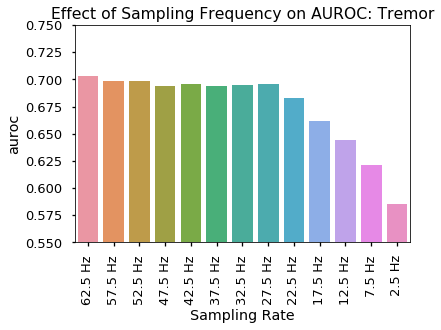

In [58]:
groups = sensor_res_all['Sampling Rate']
aurocall = sensor_res_all['auroc']
sns.barplot(groups,aurocall)
ax=plt.xticks(rotation=90)
plt.ylim([0.55,0.75])
plt.title('Effect of Sampling Frequency on AUROC: Tremor')

In [59]:
symptom = 'Bradykinesia'

sensor_res_all = pd.DataFrame()

t1=time.time()

for freq in [62.5,57.5,52.5,47.5,42.5,37.5,32.5,27.5,22.5,17.5,12.5,7.5,2.5]:
    
    print(freq)

    Dataorig = pd.read_csv('Z:CIS-PD Study\\Accel Data ' + str(freq) + 'Hz.csv',index_col=0)
    Dataorig = Dataorig.reset_index(drop=True)

    Dataorig=Dataorig[Dataorig.Subject!=1020]

    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    for s in Data.columns.values[4:]:
        Data = Data[Data[s]<np.finfo(np.float32).max]
    Data=Data.reset_index(drop=True) #reset index

    X = Data.iloc[:,5:].as_matrix()
    fnames = Data.iloc[:,5:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
    model_name = ['Random Forest']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X,y,groups,models)
    res['Sampling Rate'] = str(freq) + ' Hz'
    res['auroc std'] = np.nanstd(res_group['Random Forest']['auroc'])
    res = res[['Sampling Rate','auroc','auroc std']]
    sensor_res_all = pd.concat((sensor_res_all,res))

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

62.5
Rows w Bradykinesia 19503/37498 = 0.52
Training Random Forest

Subj/Visit 0, prec=0.492, rec=0.480, Spec=0.715, auroc_train=1.000, auroc=0.641

Subj/Visit 1, prec=0.942, rec=0.685, Spec=0.680, auroc_train=1.000, auroc=0.777

Subj/Visit 2, prec=0.706, rec=0.697, Spec=0.609, auroc_train=1.000, auroc=0.720

Subj/Visit 3, prec=0.448, rec=0.910, Spec=0.506, auroc_train=1.000, auroc=0.795

Subj/Visit 4, prec=0.751, rec=0.572, Spec=0.629, auroc_train=1.000, auroc=0.652

Subj/Visit 5, prec=0.614, rec=0.637, Spec=0.477, auroc_train=1.000, auroc=0.572

Subj/Visit 6, prec=0.643, rec=0.753, Spec=0.570, auroc_train=1.000, auroc=0.730

Subj/Visit 7, prec=0.888, rec=0.608, Spec=0.466, auroc_train=1.000, auroc=0.556

Subj/Visit 8, prec=0.345, rec=0.604, Spec=0.490, auroc_train=1.000, auroc=0.567

Subj/Visit 9, prec=0.591, rec=0.721, Spec=0.543, auroc_train=1.000, auroc=0.697

Subj/Visit 10, prec=0.519, rec=0.534, Spec=0.627, auroc_train=1.000, auroc=0.638

Subj/Visit 11, prec=0.195, rec=0.650, Sp


Subj/Visit 16, prec=0.716, rec=0.708, Spec=0.692, auroc_train=1.000, auroc=0.762

Subj/Visit 17, prec=0.601, rec=0.642, Spec=0.554, auroc_train=1.000, auroc=0.653

Subj/Visit 18, prec=0.931, rec=0.483, Spec=0.628, auroc_train=1.000, auroc=0.549
f1_test=0.585+/-0.132, prec=0.591+/-0.215, rec=0.638+/-0.102, auprc=0.628+/-0.203, auroc=0.662+/-0.079
37.5
Rows w Bradykinesia 19503/37498 = 0.52
Training Random Forest

Subj/Visit 0, prec=0.454, rec=0.465, Spec=0.679, auroc_train=1.000, auroc=0.622

Subj/Visit 1, prec=0.942, rec=0.687, Spec=0.680, auroc_train=1.000, auroc=0.766

Subj/Visit 2, prec=0.702, rec=0.685, Spec=0.607, auroc_train=1.000, auroc=0.701

Subj/Visit 3, prec=0.436, rec=0.867, Spec=0.506, auroc_train=1.000, auroc=0.781

Subj/Visit 4, prec=0.773, rec=0.609, Spec=0.649, auroc_train=1.000, auroc=0.678

Subj/Visit 5, prec=0.620, rec=0.643, Spec=0.486, auroc_train=1.000, auroc=0.569

Subj/Visit 6, prec=0.641, rec=0.748, Spec=0.567, auroc_train=1.000, auroc=0.726

Subj/Visit 7, pr


Subj/Visit 12, prec=0.635, rec=0.585, Spec=0.510, auroc_train=1.000, auroc=0.556

Subj/Visit 13, prec=0.247, rec=0.659, Spec=0.547, auroc_train=1.000, auroc=0.656

Subj/Visit 14, prec=0.697, rec=0.634, Spec=0.683, auroc_train=1.000, auroc=0.733

Subj/Visit 15, prec=0.307, rec=0.751, Spec=0.531, auroc_train=1.000, auroc=0.685

Subj/Visit 16, prec=0.707, rec=0.691, Spec=0.686, auroc_train=1.000, auroc=0.757

Subj/Visit 17, prec=0.590, rec=0.620, Spec=0.549, auroc_train=1.000, auroc=0.646

Subj/Visit 18, prec=0.931, rec=0.470, Spec=0.640, auroc_train=1.000, auroc=0.551
f1_test=0.590+/-0.133, prec=0.594+/-0.215, rec=0.647+/-0.101, auprc=0.622+/-0.206, auroc=0.666+/-0.073
12.5
Rows w Bradykinesia 18102/34959 = 0.52
Training Random Forest

Subj/Visit 0, prec=0.469, rec=0.477, Spec=0.690, auroc_train=1.000, auroc=0.636

Subj/Visit 1, prec=0.941, rec=0.679, Spec=0.662, auroc_train=1.000, auroc=0.738

Subj/Visit 2, prec=0.713, rec=0.687, Spec=0.626, auroc_train=1.000, auroc=0.719

Subj/Visit 3

In [60]:
sensor_res_all

,Sampling Rate,auroc,auroc std
0,62.5 Hz,0.670675,0.078600
0,57.5 Hz,0.665114,0.079430
0,52.5 Hz,0.664915,0.080458
0,47.5 Hz,0.663434,0.080335
0,42.5 Hz,0.662009,0.078894
0,37.5 Hz,0.661887,0.079809
0,32.5 Hz,0.664367,0.076564
0,27.5 Hz,0.665312,0.076548
0,22.5 Hz,0.665223,0.073486
0,17.5 Hz,0.665852,0.072609


Text(0.5,1,'Effect of Sampling Frequency on AUROC: Bradykinesia')

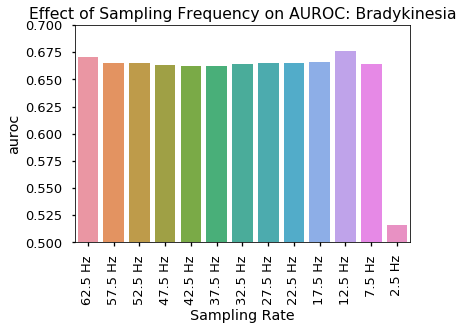

In [62]:
groups = sensor_res_all['Sampling Rate']
aurocall = sensor_res_all['auroc']
sns.barplot(groups,aurocall)
ax=plt.xticks(rotation=90)
plt.ylim([0.5,0.7])
plt.title('Effect of Sampling Frequency on AUROC: Bradykinesia')